In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

In [2]:
!pip install ucimlrepo
!pip install torch
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from ucimlrepo import fetch_ucirepo
import numpy as np
from scipy.stats import uniform, randint
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [19]:
from model_wizard import buscar_melhor_wisard
from metricas import plot_confusion_matrix, classification_metrics

## Segundo Dataset

In [20]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 
  
# metadata 
print(heart_disease.metadata) 
  
# variable information 
print(heart_disease.variables) 

print ("Targets:")
print(y[y.columns[0]].unique())

{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'ID': 231, 'type': 'NATIVE', 'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M

### Visualização de datasets

In [21]:
print("Features:")
print(X.head())
print("\nTargets:")
print(y)

# Identificar colunas categóricas e numéricas
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(include=['number']).columns.tolist()

print("\nColunas categóricas:", categorical_cols)
print("Colunas numéricas:", numeric_cols)

Features:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

    ca  thal  
0  0.0   6.0  
1  3.0   3.0  
2  2.0   7.0  
3  0.0   3.0  
4  0.0   3.0  

Targets:
     num
0      0
1      2
2      1
3      0
4      0
..   ...
298    1
299    2
300    3
301    1
302    0

[303 rows x 1 columns]

Colunas categóricas: []
Colunas numéricas: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


### Tratamento de Dados

In [22]:
# OneHotEncoder para as variáveis categóricas
ohe = OneHotEncoder(sparse_output=False)
X_categorical_encoded = ohe.fit_transform(X[categorical_cols])

# Nomes das colunas para as variáveis categóricas
categorical_column_names = ohe.get_feature_names_out(categorical_cols)

# Normalizar atributos numéricos
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X[numeric_cols])

# Concatenar os dados (numéricos e categóricos)
X_processed = np.hstack((X_numeric_scaled, X_categorical_encoded))

# Criar um DataFrame com os nomes das colunas
X_processed_df = pd.DataFrame(X_processed, columns=np.concatenate([numeric_cols, categorical_column_names]))

# Garantir que y seja 1D
y = heart_disease.data.targets.squeeze()

# Exibir verificação
if len(y.shape) > 1:
    print("y ainda é multidimensional. Forma de y:", y.shape)
else:
    print("y é unidimensional.")

# Convertendo y para uma série do pandas para facilitar a visualização
y_series = pd.Series(y)

# Exibindo os dados processados e o target
print("Dados de entrada (X) processados:")
print(X_processed_df.head())

print("Target (y) original ajustado:")
print(np.unique(y))
classes, counts = np.unique(y, return_counts=True)
for label, count in zip(classes, counts):
    print(f"{label}: {count}")


y é unidimensional.
Dados de entrada (X) processados:
        age       sex        cp  trestbps      chol       fbs   restecg  \
0  0.948726  0.686202 -2.251775  0.757525 -0.264900  2.394438  1.016684   
1  1.392002  0.686202  0.877985  1.611220  0.760415 -0.417635  1.016684   
2  1.392002  0.686202  0.877985 -0.665300 -0.342283 -0.417635  1.016684   
3 -1.932564  0.686202 -0.165268 -0.096170  0.063974 -0.417635 -0.996749   
4 -1.489288 -1.457296 -1.208521 -0.096170 -0.825922 -0.417635  1.016684   

    thalach     exang   oldpeak     slope        ca      thal  
0  0.017197 -0.696631  1.087338  2.274579 -0.718306  0.653650  
1 -1.821905  1.435481  0.397182  0.649113  2.487269 -0.895552  
2 -0.902354  1.435481  1.346147  0.649113  1.418744  1.170051  
3  1.637359 -0.696631  2.122573  2.274579 -0.718306 -0.895552  
4  0.980537 -0.696631  0.310912 -0.976352 -0.718306 -0.895552  
Target (y) original ajustado:
[0 1 2 3 4]
0: 164
1: 55
2: 36
3: 35
4: 13


In [16]:
# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)
# Exibe as dimensões dos conjuntos de treino e teste
print("Tamanho do conjunto de treino:", X_train.shape)
print("Tamanho do conjunto de teste:", X_test.shape)
print("Tamanho dos rótulos de treino:", y_train.shape)
print("Tamanho dos rótulos de teste:", y_test.shape)

print("\nExemplo de X_train (primeiras 5 linhas):")
print(X_train[:5])  # Exibe as 5 primeiras linhas de X_train

print("\nExemplo de y_train (primeiros 5 rótulos):")
print(y_train[:5])  # Exibe os 5 primeiros rótulos de y_train

print("\nExemplo de X_test (primeiras 5 linhas):")
print(X_test[:5])  # Exibe as 5 primeiras linhas de X_test

print("\nExemplo de y_test (primeiros 5 rótulos):")
print(y_test[:5])  # Exibe os 5 primeiros rótulos de y_test

Tamanho do conjunto de treino: (212, 13)
Tamanho do conjunto de teste: (91, 13)
Tamanho dos rótulos de treino: (212,)
Tamanho dos rótulos de teste: (91,)

Exemplo de X_train (primeiras 5 linhas):
[[ 0.50545103  0.68620244 -2.25177456  1.61121989  0.50892271 -0.41763453
   1.01668424 -1.07750662 -0.69663055 -0.89686172 -0.97635214 -0.71113139
  -0.89023814]
 [-0.71355642  0.68620244 -0.16526786 -0.43764774  0.16070235  2.394438
  -0.99674925  1.11190128 -0.69663055 -0.89686172 -0.97635214  1.43287667
  -0.89023814]
 [ 0.50545103  0.68620244  0.87798549 -1.2344296  -0.14882685 -0.41763453
   1.01668424 -0.33310794  1.43548113  0.13837295  0.64911323  0.36087264
   1.17675157]
 [ 1.61363963 -1.4572959  -2.25177456  0.47296009 -0.14882685 -0.41763453
  -0.99674925  0.06098549 -0.69663055  0.65599028 -0.97635214  1.43287667
  -0.89023814]
 [ 0.28381332  0.68620244 -0.16526786  1.04208999 -2.33487687  2.394438
  -0.99674925  1.02432497 -0.69663055 -0.7243226  -0.97635214  0.36087264
   1.176

#### Métricas

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Treinando WiSARD com n_classes=5, entry_size=13, tuple_size=8, bleaching=True
Melhores parâmetros encontrados: {'wisard__tuple_size': 8, 'wisard__bleaching': True}
Melhor acurácia: 0.5328638497652581


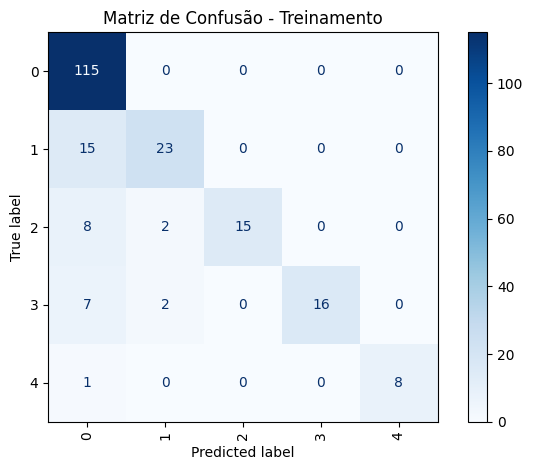

              precision    recall  f1-score   support

           0       0.79      1.00      0.88       115
           1       0.85      0.61      0.71        38
           2       1.00      0.60      0.75        25
           3       1.00      0.64      0.78        25
           4       1.00      0.89      0.94         9

    accuracy                           0.83       212
   macro avg       0.93      0.75      0.81       212
weighted avg       0.86      0.83      0.83       212



In [17]:

best_model, best_params, best_score, random_search = buscar_melhor_wisard(X_train, y_train)

print("Melhores parâmetros encontrados:", best_params)
print("Melhor acurácia:", best_score)

# Faz predição codificada
y_train_pred_encoded = random_search.predict(X_train)

# Plota matriz de confusão com labels na vertical
plot_confusion_matrix(y_train, y_train_pred_encoded, le, title="Matriz de Confusão - Treinamento")

# Imprime relatório de classificação com rótulos originais
classification_metrics(y_train, y_train_pred_encoded, le)

### Predição

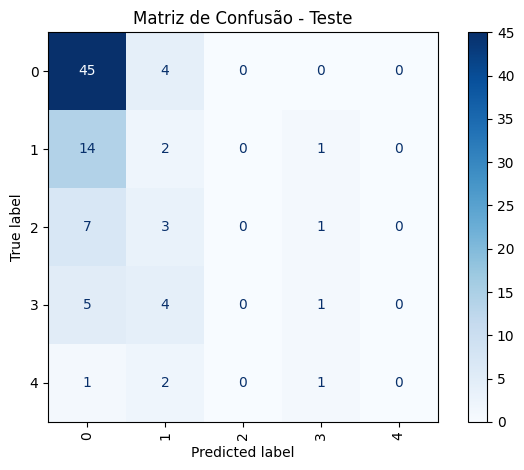

              precision    recall  f1-score   support

           0       0.62      0.92      0.74        49
           1       0.13      0.12      0.12        17
           2       0.00      0.00      0.00        11
           3       0.25      0.10      0.14        10
           4       0.00      0.00      0.00         4

    accuracy                           0.53        91
   macro avg       0.20      0.23      0.20        91
weighted avg       0.39      0.53      0.44        91

Treinando WiSARD com n_classes=5, entry_size=13, tuple_size=10, bleaching=True
[CV] END ......wisard__bleaching=True, wisard__tuple_size=10; total time=   0.0s
Treinando WiSARD com n_classes=5, entry_size=13, tuple_size=9, bleaching=False
[CV] END ......wisard__bleaching=False, wisard__tuple_size=9; total time=   0.0s
Treinando WiSARD com n_classes=5, entry_size=13, tuple_size=9, bleaching=False
[CV] END ......wisard__bleaching=False, wisard__tuple_size=9; total time=   0.0s
Treinando WiSARD com n_classes=

In [18]:
# Predição no teste
y_test_pred = random_search.predict(X_test)

plot_confusion_matrix(y_test, y_test_pred, le, title="Matriz de Confusão - Teste")
classification_metrics(y_test, y_test_pred, le)